https://www.kaggle.com/bileltaboubi/identify-and-classify-toxic-online-comments

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv')
test = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/valid_combined.csv', index_col=0)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,0,This article sucks \n\nwoo woo wooooooo
1,1,"""And yes, people should recognize that but the..."
2,2,"Western Media?\n\nYup, because every crime in..."
3,3,And you removed it! You numbskull! I don't car...
4,4,smelly vagina \n\nBluerasberry why don't you ...


In [ ]:
# Checking for null values is a common preprocessing step.
# Null values will affect the model results

In [ ]:
print(train.isnull().any())
print('--------------------')
print(test.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool
--------------------
id              False
comment_text    False
dtype: bool


In [ ]:
# cleaning the data

In [ ]:
# remove punctuation

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\t', '', text)
    return text


train['comment_text'] = train['comment_text'].apply(lambda x: remove_punct(x))
test['comment_text'] = test['comment_text'].apply(lambda x: remove_punct(x))

In [ ]:
# remove uppercases

def lower(text):
    lowercase_text = [word.lower() for word in text.split()]
    text=" ".join(lowercase_text)
    return text

  
train['comment_text'] = train['comment_text'].apply(lambda x: lower(x))
test['comment_text'] = test['comment_text'].apply(lambda x: lower(x))

In [ ]:
###########

# Sometimes, remove punctuations and lower cases will reduce the accuracy
# coz the punctuations such as " s#$t " are used to express bad words, " =] " are happy face

In [ ]:
# split them into X and Y sets

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
# Preparation before feeding into the LSTM model

# 1. Tokenization
     # - break down sentences into unique words, e.g. "I love cats and love dogs" ---> ["I", "love", "cats", "and", "dogs"]

# 2. Indexing
     # - put the words into a dictionary-like structure and assign each of the words an index,
     #   e.g. {1:"I", 2:"love", 3:"cats", 4:"and", 5:"dogs"}

# 3. Index Representation
     # - represent the sequence of words in the form of index, and feed this chain of index into LSTM
     #   e.g. [1, 2, 3, 4, 5]    


In [ ]:
# Define the number of unique words in the dictionary when tokenizing sentences
# picked 20000

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
# check that Keras has converted words into index representation by the above " .texts_to_sequences() "

list_tokenized_train[:1]

[[1,
  121,
  124,
  170,
  27,
  625,
  4462,
  11292,
  1029,
  81,
  303,
  52,
  2015,
  10738,
  51,
  6428,
  15,
  61,
  2598,
  143,
  7,
  2734,
  33,
  112,
  1129,
  15563,
  2804,
  4,
  48,
  54,
  231,
  1,
  414,
  30,
  1,
  40,
  29,
  141,
  71,
  3370,
  91]]

In [ ]:
# check the distribution of the number of words in sentences

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [ ]:
# Make sure all the data have a consistent length (same number of features)

# Eaxmple:
# comment1 = [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
# comment2 = [1,2]

# solve by "padding", filling in zeros
# comment1 = [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
# comment2 = [1,2,0,0,0,0,0,0,0,0,0,0,0,0]

#############################################
# how to set the length of data (number of features)???
# if too short, some useful features might be lost and lead to a reduce in accuracy.
# if too long, LSTM cells need to be larger to store the possible values or states

# Lets see the distribution of the number of words in sentences

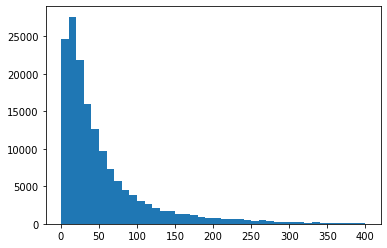

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [ ]:
# As observed, most of the sentences' length are around 30.
# We could set the "maxlen" to 50 but to avoid any kind of information loss, we extend it to 200.

maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
# the comments are now encoded and are ready to be fed into the model

 **Building Model**

In [ ]:
# General Architecture of our Model

#####################################################################################################


# Input Layer --> Embedding Layer --> LSTM --> Max Pooling --> Dropout --> Dense --> Dropout -->Dense


#####################################################################################################

In [ ]:
# 1. Input Layer

# The inputs are the list of encoded sentences. Define an input layer that accepts a list of sentences that has dimension of 200.

inp = Input(shape=(maxlen, ))

# By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [ ]:
# 2. Embedding Layer

# Then, words are projected to a defined vector space depending on the distance of the surrounding words in a sentence.
# Embedding reduces model size and most importantly avoids the huge dimension created if one-hot encoding is applied.

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

 - Embedding size (vector size) is a parameter that can be tuned.

 - Embedding function will return a 3-D tensor.

 - Tensors are simply mathematical objects that can be used to describe physical properties, just like scalars and vectors. In fact, tensors are merely a generalisation of scalars and vectors; a scalar is a zero rank tensor, and a vector is a first rank tensor.

In [ ]:
# Next, we feed this Tensor into the LSTM layer. 
# We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results.

# LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network and take the final output after X numbers of recursion. 
# But depending on use cases, some might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer.


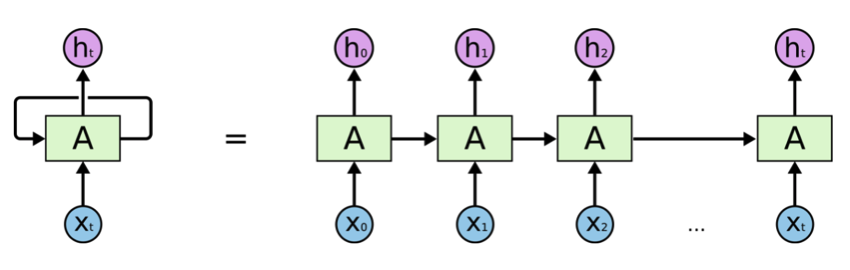

LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. 
 - Batch size is the number of samples in a batch.
 - Time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture.
 - Number of Inputs is the number of variables(number of words in each sentence in our case) pass into LSTM as pictured in "x" above.

In [ ]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

What it does is going through the samples, recursively run the LSTM model for many time (depending on the values of the tensor passed from the last cell stocked in x), passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 1, 1), where 60 is the output dimension we have defined.

In [ ]:
# 3. Max Pooling

# Before passing the output to a normal layer, the 3D tensor need to be reshaped into 2D.
# The reshape needed to be careful to avoid throwing away important data.
# Ideally, the resulting should be a good representation of the orginal data.

# Therefore, a Global Max Pooling layer (in traditional CNN problems is to reduce the dimensionality of image data) is applied.
# We go through each patch of data and take the maximum values of each patch.
# These collection of maximum values will be a new set of down-sized data we can use for next stage. 

x = GlobalMaxPool1D()(x)

In [ ]:
# regularization of neural network to reduce overfitting by using dropout and dense layers

# In 2D tensor, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced
# to handle the representation of the missing data and the whole network could result in better generalization.

x = Dropout(0.1)(x)

In [ ]:
# Then, we connect the output of Dropout layer to a densely connected layer and the output passes through a RELU function.

x = Dense(50, activation="relu")(x)

In [ ]:
x = Dropout(0.1)(x)

In [ ]:
# Finally, we feed the output into a Sigmoid layer because we want to achieve a binary classification (1,0) for each of the 6 labels.
# Sigmoid function will squash the output between the bounds of 0 and 1.

x = Dense(6, activation="sigmoid")(x)

In [ ]:
# Learning rate by default value is set at 0.001.

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# the following cell just takes 2 mins to run/train with GPU

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 66s 13ms/step - loss: 0.0691 - accuracy: 0.9545 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 57s 13ms/step - loss: 0.0470 - accuracy: 0.9878 - val_loss: 0.0496 - val_accuracy: 0.9893


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [ ]:
test.head()

,id,comment_text
0,0,this article sucks woo woo wooooooo
1,1,and yes people should recognize that but they ...
2,2,western mediayup because every crime in the en...
3,3,and you removed it you numbskull i dont care w...
4,4,smelly vagina bluerasberry why dont you be a m...


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
preds = model.predict(X_te, batch_size=1024)
test[list_classes] = preds

In [ ]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,this article sucks woo woo wooooooo,0.977131,0.037091,0.894278,0.006292,0.536276,0.024295
1,1,and yes people should recognize that but they ...,0.005516,0.000024,0.001239,0.000039,0.001114,0.000127
2,2,western mediayup because every crime in the en...,0.078159,0.000457,0.013808,0.001377,0.019195,0.003125
3,3,and you removed it you numbskull i dont care w...,0.461542,0.005596,0.067743,0.015692,0.193424,0.023769
4,4,smelly vagina bluerasberry why dont you be a m...,0.931161,0.048269,0.703632,0.018129,0.632820,0.049530


In [ ]:
def sum(x):
  sum = x.toxic + x.severe_toxic + x.obscene + x.threat + x.insult + x.identity_hate
  return sum

test["total_score"] = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].apply(sum, axis=1)

In [ ]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_score
0,0,this article sucks woo woo wooooooo,0.977131,0.037091,0.894278,0.006292,0.536276,0.024295,2.475363
1,1,and yes people should recognize that but they ...,0.005516,0.000024,0.001239,0.000039,0.001114,0.000127,0.008060
2,2,western mediayup because every crime in the en...,0.078159,0.000457,0.013808,0.001377,0.019195,0.003125,0.116121
3,3,and you removed it you numbskull i dont care w...,0.461542,0.005596,0.067743,0.015692,0.193424,0.023769,0.767767
4,4,smelly vagina bluerasberry why dont you be a m...,0.931161,0.048269,0.703632,0.018129,0.632820,0.049530,2.383542
...,...,...,...,...,...,...,...,...,...
60211,60211,get out my large penis,0.979351,0.080225,0.925208,0.011463,0.590800,0.038213,2.625260
60212,60212,get out my large penis,0.979351,0.080225,0.925208,0.011463,0.590800,0.038213,2.625260
60213,60213,piss off you slant eyedgook,0.911224,0.042098,0.372128,0.030619,0.592435,0.066836,2.015340
60214,60214,piss off you slant eyedgook,0.911224,0.042098,0.372128,0.030619,0.592435,0.066836,2.015340


In [ ]:
#test.to_csv('gdrive/MyDrive/Colab Notebooks/test_result.csv')